In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
df_1 = pd.read_csv('KCDH2024_Training_GroundTruth.csv')
df_2 = pd.read_csv('KCDH2024_Training_LesionGroupings.csv')

In [3]:
df_1.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0,1,0,0,0,0,0
1,ISIC_0024307,0,1,0,0,0,0,0
2,ISIC_0024308,0,1,0,0,0,0,0
3,ISIC_0024309,0,1,0,0,0,0,0
4,ISIC_0024310,1,0,0,0,0,0,0


In [4]:
df_2.head()

,image,lesion_id,diagnosis_confirm_type
0,ISIC_0024306,HAM_0000550,serial imaging showing no change
1,ISIC_0024307,HAM_0003577,serial imaging showing no change
2,ISIC_0024308,HAM_0001477,serial imaging showing no change
3,ISIC_0024309,HAM_0000484,serial imaging showing no change
4,ISIC_0024310,HAM_0003350,histopathology


In [5]:
l_dx = []
for rows in df_1.iterrows():
    l_dx.append(np.argmax(rows[1][1::]))

In [6]:
l_dx = np.array(l_dx)
l_dx

array([1, 1, 1, ..., 4, 1, 1], dtype=int64)

In [7]:
df_1['dx'] = l_dx

In [8]:
mer_df = pd.merge(df_1[['image','dx']],df_2[['image','lesion_id']],on = 'image')[['image','lesion_id','dx']]

In [9]:
mer_df.head()

,image,lesion_id,dx
0,ISIC_0024306,HAM_0000550,1
1,ISIC_0024307,HAM_0003577,1
2,ISIC_0024308,HAM_0001477,1
3,ISIC_0024309,HAM_0000484,1
4,ISIC_0024310,HAM_0003350,0


In [10]:
# Only keeping those images which are in the training folder
imgs_in_folder = [img[:-4] for img in os.listdir('KCDH2024_Training_Input_10K/KCDH2024_Training_Input_10K/')]
imgs_in_df = mer_df['image'].unique()

In [11]:
(np.isin(imgs_in_df, imgs_in_folder) == False).sum()
# 415 images are there in df but not in the folder

415

In [12]:
mer_df = mer_df[np.isin(imgs_in_df, imgs_in_folder)]
df_count = mer_df.groupby('lesion_id').count()
df_count.head()

,image,dx
lesion_id,,
HAM_0000000,2,2
HAM_0000001,1,1
HAM_0000002,2,2
HAM_0000003,1,1
HAM_0000004,1,1


In [13]:
df_count = df_count[df_count['dx']==1].reset_index()
df_count.head()

,lesion_id,image,dx
0,HAM_0000001,1,1
1,HAM_0000003,1,1
2,HAM_0000004,1,1
3,HAM_0000007,1,1
4,HAM_0000008,1,1


In [14]:
def duplicate(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'yes'

In [15]:
mer_df['is_duplicate'] = mer_df['lesion_id'].apply(duplicate)
mer_df.head()

,image,lesion_id,dx,is_duplicate
0,ISIC_0024306,HAM_0000550,1,no
1,ISIC_0024307,HAM_0003577,1,no
2,ISIC_0024308,HAM_0001477,1,no
3,ISIC_0024309,HAM_0000484,1,no
4,ISIC_0024310,HAM_0003350,0,yes


In [16]:
df_count = mer_df[mer_df['is_duplicate'] == 'no']

# train - test split
train, test_df = train_test_split(df_count, test_size = 0.15, stratify = df_count['dx'])

In [17]:
def identify_train_OR_test(x):
    test_data = set(test_df['image'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

In [18]:
mer_df['train_OR_test'] = mer_df['image'].apply(identify_train_OR_test)
train_df = mer_df[mer_df['train_OR_test']=='train']
train_df.head()

,image,lesion_id,dx,is_duplicate,train_OR_test
0,ISIC_0024306,HAM_0000550,1,no,train
1,ISIC_0024307,HAM_0003577,1,no,train
2,ISIC_0024308,HAM_0001477,1,no,train
3,ISIC_0024309,HAM_0000484,1,no,train
4,ISIC_0024310,HAM_0003350,0,yes,train


In [19]:
# test data only have values which were only uniquely present in lesion_id
test_df['is_duplicate'].unique()

array(['no'], dtype=object)

In [20]:
train_df.sort_values(by = 'lesion_id')

,image,lesion_id,dx,is_duplicate,train_OR_test
4192,ISIC_0028498,HAM_0000000,1,yes,train
1040,ISIC_0025346,HAM_0000000,1,yes,train
8316,ISIC_0032622,HAM_0000002,0,yes,train
9542,ISIC_0033848,HAM_0000002,0,yes,train
3580,ISIC_0027886,HAM_0000003,1,no,train
...,...,...,...,...,...
9072,ISIC_0033378,HAM_0007625,4,yes,train
6994,ISIC_0031300,HAM_0007626,1,no,train
1812,ISIC_0026118,HAM_0007627,2,yes,train
5514,ISIC_0029820,HAM_0007627,2,yes,train


In [21]:
train_df = train_df.drop_duplicates(subset = 'lesion_id')
train_df

,image,lesion_id,dx,is_duplicate,train_OR_test
0,ISIC_0024306,HAM_0000550,1,no,train
1,ISIC_0024307,HAM_0003577,1,no,train
2,ISIC_0024308,HAM_0001477,1,no,train
3,ISIC_0024309,HAM_0000484,1,no,train
4,ISIC_0024310,HAM_0003350,0,yes,train
...,...,...,...,...,...
9576,ISIC_0033882,HAM_0006644,1,no,train
9579,ISIC_0033885,HAM_0005737,0,no,train
9590,ISIC_0033896,HAM_0004349,1,no,train
9592,ISIC_0033898,HAM_0003812,1,no,train


In [22]:
# Image id of train and test images
train_list = list(train_df['image'])
test_list = list(test_df['image'])
len(train_list), len(test_list)

(6562, 840)

In [23]:
train_dir = 'train_dir'
test_dir = 'test_dir'

In [24]:
os.makedirs(train_dir,exist_ok = True)
os.makedirs(test_dir, exist_ok = True)

In [25]:
for i in range(0,7):
  directory1=train_dir+'/'+str(i)
  directory2=test_dir+'/'+str(i)
  os.mkdir(directory1)
  os.mkdir(directory2)

In [26]:
mer_df = mer_df.set_index('image')
mer_df.head()

,lesion_id,dx,is_duplicate,train_OR_test
image,,,,
ISIC_0024306,HAM_0000550,1,no,train
ISIC_0024307,HAM_0003577,1,no,train
ISIC_0024308,HAM_0001477,1,no,train
ISIC_0024309,HAM_0000484,1,no,train
ISIC_0024310,HAM_0003350,0,yes,train


In [27]:
for img in train_list:
    file_name = img+'.jpg'
    label = str(mer_df.loc[img,'dx'])

    source = os.path.join('KCDH2024_Training_Input_10K/KCDH2024_Training_Input_10K/',file_name)

    target = os.path.join(train_dir, label, file_name)
    shutil.copyfile(source, target)


In [28]:
for img in test_list:
    file_name = img+'.jpg'
    label = str(mer_df.loc[img,'dx'])

    source = os.path.join('KCDH2024_Training_Input_10K/KCDH2024_Training_Input_10K/',file_name)

    target = os.path.join(test_dir, label, file_name)
    shutil.copyfile(source, target)

In [29]:
# resizing the images to 299x299x3 
import cv2
import numpy as np
from PIL import Image
from PIL import ImageFilter
import os

path = train_dir
path_299 = 'train_299'
os.makedirs(path_299, exist_ok = True)
for c in os.listdir(path):
    new_folder_path = os.path.join(path_299, c)
    os.makedirs(new_folder_path, exist_ok = True)
    folder_path = os.path.join(path,c)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        load_img=cv2.imread(img_path)
        load_img = cv2.resize(load_img, (299,299))
        fullOutPath = os.path.join(new_folder_path,'resized_'+img_name)
        cv2.imwrite(fullOutPath,load_img)

In [30]:
path = test_dir
path_299 = 'test_299'
os.makedirs(path_299, exist_ok = True)
for c in os.listdir(path):
    new_folder_path = os.path.join(path_299, c)
    os.makedirs(new_folder_path, exist_ok = True)
    folder_path = os.path.join(path,c)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        load_img=cv2.imread(img_path)
        load_img = cv2.resize(load_img, (299,299))
        fullOutPath = os.path.join(new_folder_path,'resized_'+img_name)
        cv2.imwrite(fullOutPath,load_img)

In [31]:
train_dir = 'train_299'
test_dir = 'test_299'

# Data Augmentation

In [32]:
for img_class in range(0,7):
    img_class = str(img_class)
    aug_dir = 'aug_train'
    os.makedirs(aug_dir, exist_ok = True)

    os.makedirs(os.path.join(aug_dir, img_class), exist_ok = True)

    img_list = os.listdir(os.path.join(train_dir, img_class))

    for img_name in img_list:
        source = os.path.join(train_dir,img_class, img_name)
        target = os.path.join(aug_dir, img_class, img_name)

        shutil.copy(source, target)

    source_path = aug_dir

    save_path = aug_dir+'/'+img_class

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 180,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 0.1,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest'
    )
    batch_size = 50

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format='jpg',
        target_size=(299, 299),
        batch_size=batch_size
    )
    aug_images = 8000

    num_files = len(os.listdir(os.path.join(aug_dir, img_class)))
    num_batches = int(np.ceil((aug_images-num_files)/batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)



Found 567 images belonging to 1 classes.
Found 12310 images belonging to 2 classes.
Found 15956 images belonging to 3 classes.
Found 23911 images belonging to 4 classes.
Found 32361 images belonging to 5 classes.
Found 39778 images belonging to 6 classes.
Found 47816 images belonging to 7 classes.


In [33]:
train_path = 'aug_train'
test_path = test_dir

In [34]:
batch_size = 16

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input
)
image_size = 299
print("Train Batches: \n")
train_batches = datagen.flow_from_directory(
    directory = train_path,
    target_size = (image_size, image_size),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'categorical'
)
validation_batch = datagen.flow_from_directory(
    directory = test_path,
    target_size = (image_size, image_size),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'categorical'
)

Train Batches: 

Found 55766 images belonging to 7 classes.
Found 840 images belonging to 7 classes.


In [35]:
test_batch=datagen.flow_from_directory(
    directory='KCDH2024_Test_Input/',
    target_size=(image_size,image_size),
    shuffle=False,
    batch_size=batch_size,
    class_mode=None
)

Found 1512 images belonging to 1 classes.


In [36]:
from sklearn.utils import class_weight
import numpy as np
class_weights2 = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_batches.classes), y=train_batches.classes)

In [37]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [38]:
irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last 28 layers of the model.
conv = irv2.layers[-28].output


In [39]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


In [40]:
output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)

In [51]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

 batch_normalization_208 (Batch  (None, 35, 35, 96)  288         ['conv2d_208[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_210 (Batch  (None, 35, 35, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_213 (Batch  (None, 35, 35, 96)  288         ['conv2d_213[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_214 (Batch  (None, 35, 35, 64)  192         ['conv2d_214[0][0]']             
 Normaliza

 activation_225 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_224[0][0]']
                                                                                                  
 conv2d_222 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_225 (Conv2D)            (None, 35, 35, 48)   13824       ['activation_225[0][0]']         
                                                                                                  
 batch_normalization_222 (Batch  (None, 35, 35, 32)  96          ['conv2d_222[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_225 (Batch  (None, 35, 35, 48)  144         ['conv2d_225[0][0]']             
 Normaliza

                                                                                                  
 activation_228 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_227[0][0]']
                                                                                                  
 activation_230 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_229[0][0]']
                                                                                                  
 activation_233 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_232[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_228[0][0]',         
                                                                  'activation_230[0][0]',         
                                                                  'activation_233[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_243 (Batch  (None, 35, 35, 48)  144         ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_241 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_240[0][0]']
                                                                                                  
 activation_244 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_243[0][0]']
                                                                                                  
 conv2d_239 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_246[0][0]',         
                                                                  'activation_248[0][0]',         
                                                                  'activation_251[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 35, 35, 320)  0           ['block35_6[0][0]']              
          

 activation_262 (Activation)    (None, 35, 35, 48)   0           ['batch_normalization_261[0][0]']
                                                                                                  
 conv2d_257 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_259 (Conv2D)            (None, 35, 35, 32)   9216        ['activation_259[0][0]']         
                                                                                                  
 conv2d_262 (Conv2D)            (None, 35, 35, 64)   27648       ['activation_262[0][0]']         
                                                                                                  
 batch_normalization_257 (Batch  (None, 35, 35, 32)  96          ['conv2d_257[0][0]']             
 Normalization)                                                                                   
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_272 (Conv2D)            (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_272 (Batch  (None, 35, 35, 32)  96          ['conv2d_272[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_273 (Activation)    (None, 35, 35, 32)   0           ['batch_normalization_272[0][0]']
          

 activation_279 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_278[0][0]']
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_276[0][0]',         
                                )                                 'activation_279[0][0]',         
                                                                  'max_pooling2d_8[0][0]']        
                                                                                                  
 conv2d_280 (Conv2D)            (None, 17, 17, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_288 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_288 (Batch  (None, 17, 17, 128)  384        ['conv2d_288[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_296 (Conv2D)            (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_296 (Batch  (None, 17, 17, 128)  384        ['conv2d_296[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_297 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_296[0][0]']
                                                                                                  
 conv2d_297 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_297[0][0]']         
          

                                                                                                  
 batch_normalization_304 (Batch  (None, 17, 17, 128)  384        ['conv2d_304[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_305 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_305 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_305[0][0]']         
                                                                                                  
 batch_normalization_305 (Batch  (None, 17, 17, 160)  480        ['conv2d_305[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_313 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_312[0][0]']
                                                                                                  
 conv2d_313 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_313[0][0]']         
                                                                                                  
 batch_normalization_313 (Batch  (None, 17, 17, 160)  480        ['conv2d_313[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_314 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_313[0][0]']
                                                                                                  
 conv2d_31

 conv2d_321 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_321[0][0]']         
                                                                                                  
 batch_normalization_321 (Batch  (None, 17, 17, 160)  480        ['conv2d_321[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_322 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_321[0][0]']
                                                                                                  
 conv2d_319 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_322 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_322[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_330 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_329[0][0]']
                                                                                                  
 conv2d_327 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_330 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_330[0][0]']         
                                                                                                  
 batch_normalization_327 (Batch  (None, 17, 17, 192)  576        ['conv2d_327[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_335 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_338 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_338[0][0]']         
                                                                                                  
 batch_normalization_335 (Batch  (None, 17, 17, 192)  576        ['conv2d_335[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_338 (Batch  (None, 17, 17, 192)  576        ['conv2d_338[0][0]']             
 Normalization)                                                                                   
          

 conv2d_346 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_346[0][0]']         
                                                                                                  
 batch_normalization_343 (Batch  (None, 17, 17, 192)  576        ['conv2d_343[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_346 (Batch  (None, 17, 17, 192)  576        ['conv2d_346[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_344 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_343[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_354 (Batch  (None, 17, 17, 192)  576        ['conv2d_354[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_352 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_351[0][0]']
                                                                                                  
 activation_355 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_354[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 17, 17, 384)  0          ['activation_352[0][0]',         
          

 activation_360 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_359[0][0]']
                                                                                                  
 activation_362 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_361[0][0]']
                                                                                                  
 activation_365 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_364[0][0]']
                                                                                                  
 conv2d_360 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_360[0][0]']         
                                                                                                  
 conv2d_362 (Conv2D)            (None, 8, 8, 288)    663552      ['activation_362[0][0]']         
                                                                                                  
 conv2d_36

                                                                                                  
 activation_373 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_372[0][0]']
                                                                                                  
 conv2d_370 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_373 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_373[0][0]']         
                                                                                                  
 batch_normalization_370 (Batch  (None, 8, 8, 192)   576         ['conv2d_370[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_378 (Batch  (None, 8, 8, 192)   576         ['conv2d_378[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_381 (Batch  (None, 8, 8, 256)   768         ['conv2d_381[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_379 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_378[0][0]']
                                                                                                  
 activation_382 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_381[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_390 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_389[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_387[0][0]',         
                                                                  'activation_390[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 8, 8, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_398 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_398 (Batch  (None, 8, 8, 192)   576         ['conv2d_398[0][0]']             
 Normalization)                                                                                   
          

In [41]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [42]:
num_samples = [0 for i in range(0,7)]
for rows in mer_df.iterrows():
    num_samples[rows[1].values[1]]+=1
num_samples

[1015, 6457, 495, 327, 1055, 113, 138]

In [43]:
log_weight=[np.log(num_samples[1]/numj) for numj in num_samples]
log_weight[1]=1
log_weight

[1.8502762011505793,
 1,
 2.5683623300577767,
 2.9829599217292135,
 1.8116240467163,
 4.045532273914127,
 3.8456664074692624]

In [53]:
class_weights = {   
                    0: log_weight[0],
                    1: log_weight[1],  
                    2: log_weight[2],  
                    3: log_weight[3],  
                    4: log_weight[4], 
                    5: log_weight[5],  
                    6: log_weight[6], 
                }


checkpoint=  ModelCheckpoint(filepath = 'saved_model_best.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)


In [54]:
import PIL
import cv2

In [55]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=30, min_delta=0.001)
history = model.fit(train_batches,
                    epochs=150,
                    verbose=1,
                    validation_data=validation_batch,callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/150
2847/2847 [==============================] - 912s 316ms/step - loss: 1.8699 - accuracy: 0.6890 - val_loss: 0.6140 - val_accuracy: 0.7770
Epoch 2/150
2847/2847 [==============================] - 896s 315ms/step - loss: 0.9457 - accuracy: 0.8218 - val_loss: 0.5051 - val_accuracy: 0.8271
Epoch 3/150
2847/2847 [==============================] - 897s 315ms/step - loss: 0.6091 - accuracy: 0.8796 - val_loss: 0.4177 - val_accuracy: 0.8477
Epoch 4/150
2847/2847 [==============================] - 897s 315ms/step - loss: 0.4343 - accuracy: 0.9105 - val_loss: 0.2780 - val_accuracy: 0.9011
Epoch 5/150
2847/2847 [==============================] - 898s 315ms/step - loss: 0.3358 - accuracy: 0.9300 - val_loss: 0.2171 - val_accuracy: 0.9237
Epoch 6/150
2847/2847 [==============================] - 898s 315ms/step - loss: 0.2604 - accuracy: 0.9446 - val_loss: 0.1889 - val_accuracy: 0.9364
Epoch 7/150
2847/2847 [==============================] - 895s 314ms/step - loss: 0.2157 - accuracy: 0.9535

KeyboardInterrupt: 

In [56]:
from tensorflow.keras import models
model.load_weights("saved_model_best.hdf5")

In [32]:
val_pred=model.predict(validation_batch)

438/438 [==============================] - 40s 84ms/step


In [36]:
val_predictions=np.argmax(val_pred,axis=1)

In [40]:
(val_predictions==5).sum()

1005

In [57]:
pred2=np.argmax(model.predict(test_batch),axis=1)

95/95 [==============================] - 12s 98ms/step


In [61]:
(pred2==5).sum()

27

In [59]:
pred2

array([1, 1, 4, ..., 4, 4, 1], dtype=int64)

In [17]:
import os
import cv2
import numpy as np
import pandas as pd
def load_images_from_folder(folder):
    images=[]
    for filename in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img,(28,28))
            img_g=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            images.append(img_g)
    return images
def images_to_df(images,label):
    pixel_data=[]
    for img in images:
        img_flat=img.flatten()
        pixel_data.append(img_flat)
    df=pd.DataFrame(pixel_data)
    df['label']=label
    return df
directory="train - Copy"
folders=os.listdir(directory)
final_df=pd.DataFrame()
for folder in folders:
    folder_path=os.path.join(directory,folder)
    if os.path.isdir(folder_path):
        images=load_images_from_folder(folder_path)
        df=images_to_df(images,folder)
        final_df=pd.concat([final_df,df],ignore_index=True)
final_df=final_df.sample(frac=1).reset_index(drop=True)


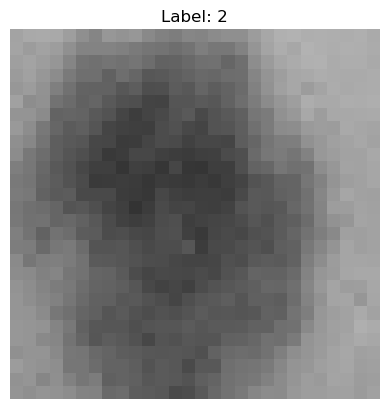

In [19]:
import matplotlib.pyplot as plt

# Assuming final_df contains the DataFrame with pixel values and labels

# Extracting the pixel values of the first image
first_image_pixels = final_df.iloc[0, :-1]  # Exclude the last column which is the label

# Reshape the pixel values to match the original image dimensions
image_shape = (28, 28)  # Assuming color images
first_image_pixels = np.array(first_image_pixels).reshape(image_shape).astype(np.uint8)


plt.imshow(cv2.cvtColor(first_image_pixels, cv2.COLOR_BGR2RGB))
plt.title(f"Label: {final_df.iloc[0, -1]}")  # Last column contains the label
plt.axis('off')
plt.show()


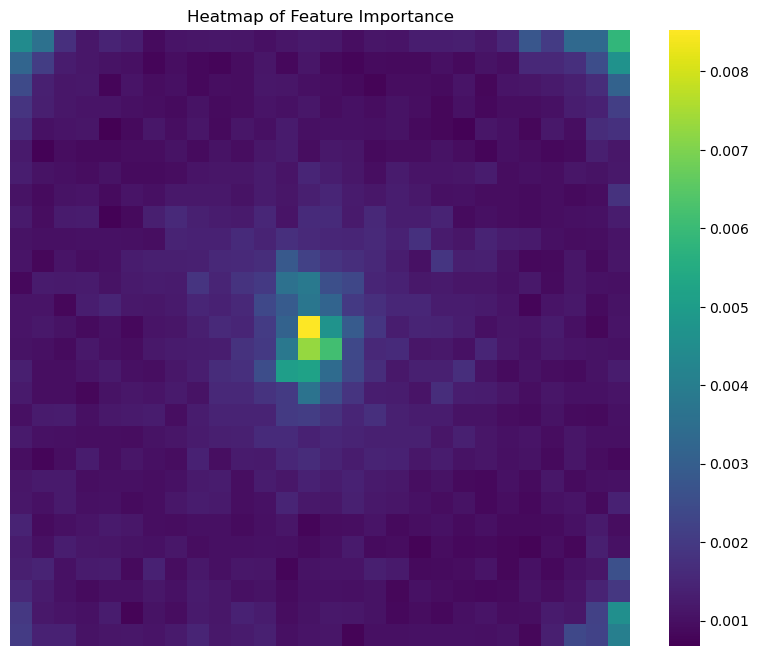

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Separate features (pixel values) and labels
X = final_df.iloc[:, :-1]  # Features
y = final_df.iloc[:, -1]   # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance
feature_importance = rf_model.feature_importances_

# Reshape feature importance to match the original image dimensions
feature_importance = feature_importance.reshape(image_shape[:2])

# Plot heatmap of feature importance
plt.figure(figsize=(10, 8))
sns.heatmap(feature_importance, cmap='viridis')
plt.title('Heatmap of Feature Importance')
plt.axis('off')
plt.show()


In [21]:
directory="train - Copy"
folders=os.listdir(directory)
folders

['1', '2', '3', '4', '5', '6', '7']